# XGBoost Model - Semiconductor Capacity Utilization
**INDENG 142A Project**

## Setup

In [2]:
!pip3 install pandas numpy xgboost scikit-learn matplotlib requests -q --break-system-packages

In [1]:
import pandas as pd
import numpy as np
import requests
import xgboost as xgb
import matplotlib.pyplot as plt
from io import StringIO
from datetime import datetime
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

## 1. Load Data from FRED

In [3]:
series = {'CAPUTLG3344S': 'CAPUTL', 'IPG3344S': 'IPG', 'DAUPSA': 'DAUP'}
data = {}

for sid, name in series.items():
    url = f"https://fred.stlouisfed.org/graph/fredgraph.csv?id={sid}&cosd=2000-01-01&coed={datetime.today().strftime('%Y-%m-%d')}"
    r = pd.read_csv(StringIO(requests.get(url).text), parse_dates=['observation_date'], index_col='observation_date')
    data[name] = pd.to_numeric(r[sid].replace('.', np.nan), errors='coerce')

df = pd.DataFrame(data).dropna()
print(f"Loaded {len(df)} observations")
df.tail()

Loaded 308 observations


,CAPUTL,IPG,DAUP
observation_date,,,
2025-04-01,78.2049,162.2271,112.3
2025-05-01,77.9551,164.2369,108.4
2025-06-01,76.2169,163.1589,112.3
2025-07-01,78.7498,171.3216,113.2
2025-08-01,76.1368,168.3425,99.5


## 2. Feature Engineering

In [4]:
# Lag features
df['CAPUTL_lag1'] = df['CAPUTL'].shift(1)
df['CAPUTL_lag3'] = df['CAPUTL'].shift(3)
df['IPG_lag1'] = df['IPG'].shift(1)
df['IPG_lag3'] = df['IPG'].shift(3)
df['DAUP_lag3'] = df['DAUP'].shift(3)

# Rolling means
df['CAPUTL_ma3'] = df['CAPUTL'].rolling(3).mean()
df['IPG_ma3'] = df['IPG'].rolling(3).mean()

# Seasonality
df['Month'] = df.index.month
df['Quarter'] = df.index.quarter

# Interaction
df['IPG_x_DAUP'] = df['IPG'] * df['DAUP']

df = df.dropna()
df.head()

,CAPUTL,IPG,DAUP,CAPUTL_lag1,CAPUTL_lag3,IPG_lag1,IPG_lag3,DAUP_lag3,CAPUTL_ma3,IPG_ma3,Month,Quarter,IPG_x_DAUP
observation_date,,,,,,,,,,,,,
2000-04-01,89.4893,6.3692,475.4,87.7378,86.3130,6.0549,5.6204,469.3,87.815933,6.066767,4,2,3027.91768
2000-05-01,91.0700,6.6909,481.2,89.4893,86.2207,6.3692,5.7762,461.2,89.432367,6.371667,5,2,3219.66108
2000-06-01,91.6385,6.9542,464.0,91.0700,87.7378,6.6909,6.0549,462.3,90.732600,6.671433,6,2,3226.74880
2000-07-01,93.1827,7.3065,455.3,91.6385,89.4893,6.9542,6.3692,475.4,91.963733,6.983867,7,3,3326.64945
2000-08-01,91.4148,7.4126,466.3,93.1827,91.0700,7.3065,6.6909,481.2,92.078667,7.224433,8,3,3456.49538


## 3. Train/Test Split

In [5]:
features = ['CAPUTL_lag1', 'CAPUTL_lag3', 'IPG_lag1', 'IPG_lag3', 'DAUP_lag3',
            'CAPUTL_ma3', 'IPG_ma3', 'Month', 'Quarter', 'IPG_x_DAUP']

X_train = df.loc[:'2019', features]
y_train = df.loc[:'2019', 'CAPUTL']
X_test = df.loc['2020':, features]
y_test = df.loc['2020':, 'CAPUTL']

print(f"Train: {len(X_train)} | Test: {len(X_test)}")

Train: 237 | Test: 68


## 4. Hyperparameter Tuning

In [6]:
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [50, 100],
    'max_depth': [3, 5]
}

grid = GridSearchCV(
    xgb.XGBRegressor(random_state=42),
    param_grid,
    cv=TimeSeriesSplit(n_splits=3),
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)

Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}


## 5. Evaluate Model

In [7]:
y_pred = grid.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test MAE:  {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")

Test MAE:  0.9961
Test RMSE: 1.2377


## 6. Feature Importance

In [8]:
importance = pd.DataFrame({
    'Feature': features,
    'Importance': grid.best_estimator_.feature_importances_
}).sort_values('Importance', ascending=False)

importance

,Feature,Importance
0,CAPUTL_lag1,0.473124
5,CAPUTL_ma3,0.458687
9,IPG_x_DAUP,0.021591
1,CAPUTL_lag3,0.017631
2,IPG_lag1,0.016109
3,IPG_lag3,0.005239
7,Month,0.005038
4,DAUP_lag3,0.002582
6,IPG_ma3,0.000000
8,Quarter,0.000000


## 7. Visualizations

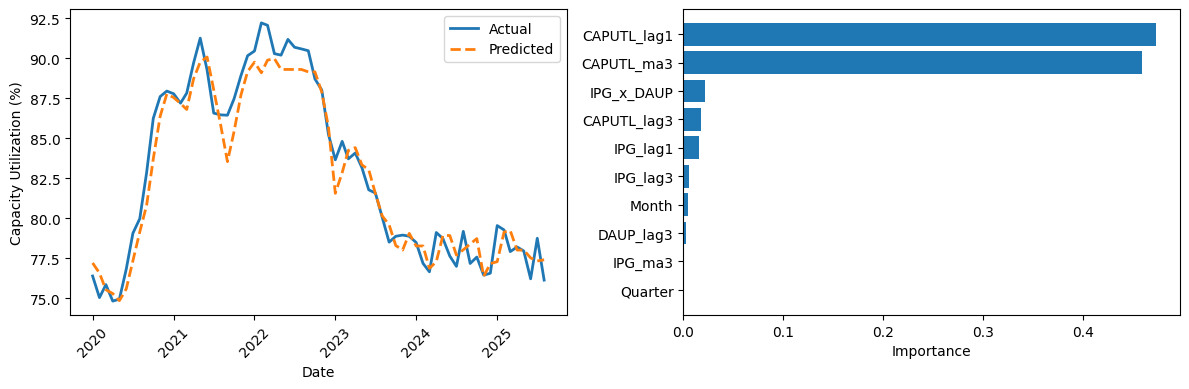

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Predictions vs Actual
ax1.plot(y_test.index, y_test, label='Actual', linewidth=2)
ax1.plot(y_test.index, y_pred, '--', label='Predicted', linewidth=2)
ax1.set_xlabel('Date')
ax1.set_ylabel('Capacity Utilization (%)')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# Feature Importance
ax2.barh(importance['Feature'], importance['Importance'])
ax2.set_xlabel('Importance')
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig('xgboost_results.png', dpi=150)
plt.show()